In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import gurobipy as grb
import os
import time

# EX 3

## 1.Load data

In [2]:
f = scipy.io.loadmat('flow.mat')["flow"].reshape(28,)
C = scipy.io.loadmat('capacities.mat')["capacities"].reshape(28,)
B = scipy.io.loadmat('traffic.mat')["traffic"]
l = scipy.io.loadmat('traveltime.mat')["traveltime"].reshape(28,)

## 2. Define graph

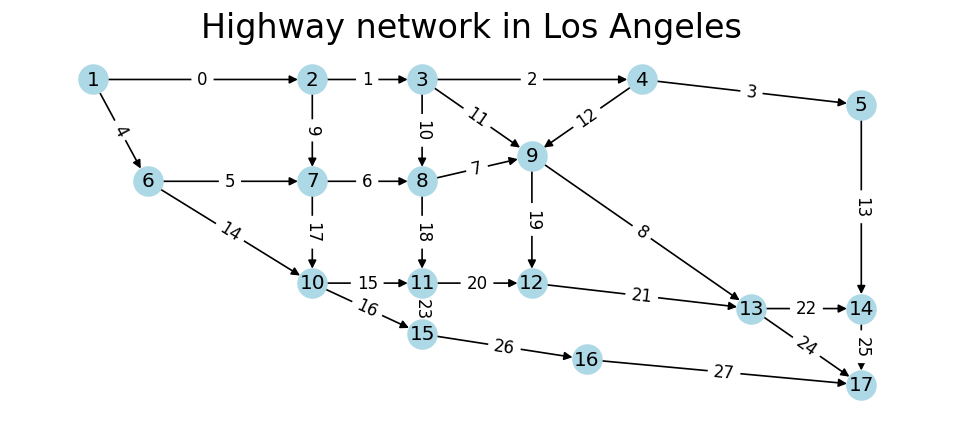

In [3]:
fig, ax = plt.subplots(figsize = (10,4), dpi=120)


n_edges = B.shape[1]
n_nodes = B.shape[0]

G = nx.DiGraph()
G.add_nodes_from(range(1,n_nodes+1))
edge_labels={}

for j in range(n_edges):
  for i in range(0,n_nodes):
    if(B[i][j] == 1):
      start = i + 1 # node i is the start of the edge. #The plus 1 is because we started from 1 in graph generation
    if(B[i][j] == -1):
      end = i + 1 # i don't like tail and head notation
  # inside the loop inside the edges
  G.add_edges_from([(start,end)])
  edge_labels[(start,end)] = str(j)
  G[start][end]['capacity'] = C[j]
  G[start][end]['weight'] = l[j]
pos = {1:[0,0], 2:[4,0], 3:[6,0], 4:[10,0], 5:[14, -1], 6:[1,-4], 7:[4,-4],8:[6,-4],9:[8, -3],
       10:[4, -8],11:[6, -8],12:[8, -8],13:[12, -9],14:[14, -9],15:[6, -10],16:[9, -11],17:[14, -12]}

nx.draw(G, pos, with_labels = True, node_color = 'lightblue')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

ax.set_title("Highway network in Los Angeles ", fontsize=20)
plt.savefig('fig/graph1.png')




## 3. Solve problems

### a) Find the shortest path

#### For shortest path problem we set a unitary flow from origin to destination

In [4]:
#Defining external flow in the problem of Shortest Path
v = np.zeros(17)
v[0] = 1
v[16] = -1

#### Formulating shortest path problem as a linear program

In [5]:
model = grb.Model('gbpp')
f_ = model.addMVar(
    (n_edges,),
    vtype = grb.GRB.INTEGER,
    lb = 0,
    name = 'f'
)
edges = range(n_edges)
nodes = range(n_nodes)
expr = 0
expr += l @ f_
model.setObjective(expr,grb.GRB.MINIMIZE)
model.addConstrs(
  B[n,:] @ f_ == v[n] for n in nodes
)

model.update()


#model.setParam('MIPgap', 0.01)
model.setParam(grb.GRB.Param.TimeLimit, 300)
model.setParam('OutputFlag', 1)

start = time.time()
model.optimize()
end = time.time()
comp_time = end - start
print(f"computational time: {comp_time} s")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-09
Set parameter TimeLimit to value 300
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 28 columns and 56 nonzeros
Model fingerprint: 0x0689db14
Variable types: 0 continuous, 28 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.6586590
Presolve removed 17 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 0.532996 0.658659 

Optimal solution found (tolerance 1.00e-04)
B

#### Get result

In [7]:
optimal_f = []

for f_ in model.getVars():
    optimal_f.append(f_.X)

optimal_f = np.array(optimal_f)

#### Compare result

In [8]:
result =  list(np.unique(np.argwhere(B[:,np.array(optimal_f, dtype = bool)] != 0).transpose()[0]) + 1)

print(f'solution of linear program : {result}')
print(f'the true solution : {nx.shortest_path(G,1,17)}')

solution of linear program : [1, 2, 3, 9, 13, 17]
the true solution : [1, 2, 3, 9, 13, 17]


#### Figure

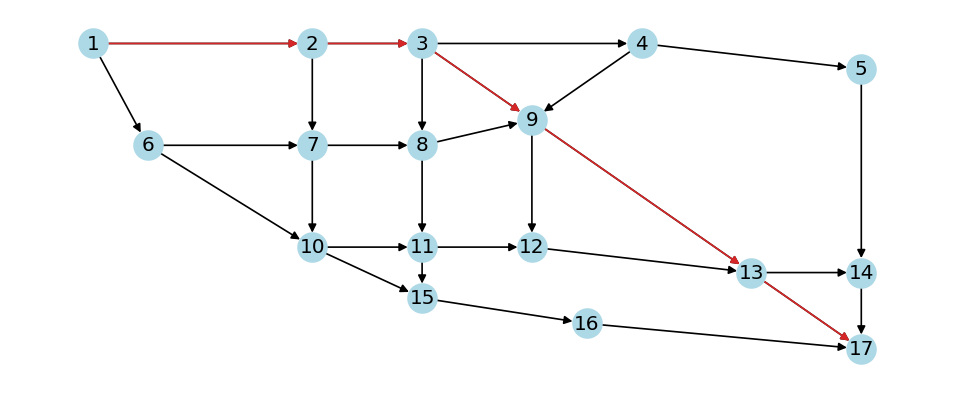

In [9]:
fig, ax = plt.subplots(figsize = (10,4), dpi=120)
nx.draw(G, pos, with_labels = True, node_color = 'lightblue')
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=[(1, 2), (2, 3), (3, 9), (9, 13), (13, 17)],
    edge_color="tab:red",
)

plt.savefig('fig/graph2.png')



### b) Find the maximum node between 1 & 17

#### Find max flow

In [10]:
max_flow, flows = nx.maximum_flow(G,1,17)

#### Figure

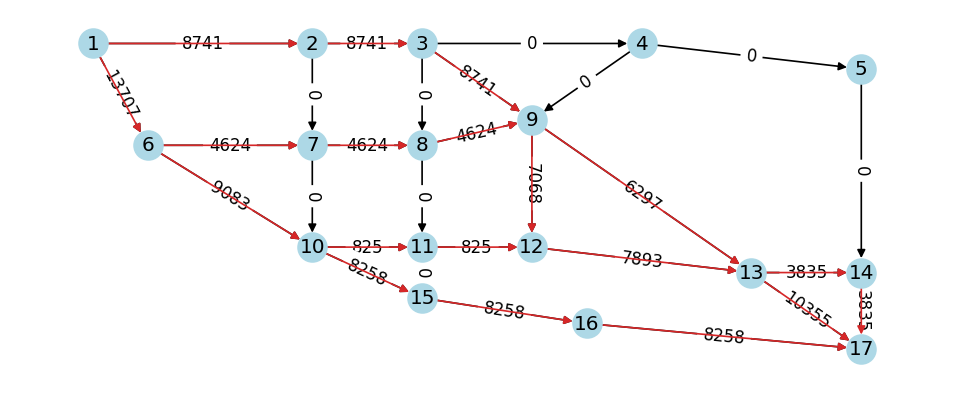

In [11]:
fig, ax = plt.subplots(figsize = (10,4), dpi=120)

edge_labels = {}
edge_list = []

for key in flows.keys():
    start = key
    for subkey in flows[key]:
        end = subkey
        edge_labels[(start, end)] = flows[start][end]
        if flows[start][end] != 0:
            edge_list.append((start, end))

nx.draw(G, pos, with_labels = True, node_color = 'lightblue')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=edge_list,
    edge_color="tab:red",
)

plt.savefig('fig/graph3.png')


### c) Compute external inflow

#### Calculate the exogenous flow given the internal flow

In [19]:
v = B @ f

#### All the positive components of v represent the exogenous inflow

In [20]:
print(v)

[ 16282   9094  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


#### Set up for next tast

In [21]:
v[1:] = 0
v[16] = -v[0]
print(v)

[ 16282      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0 -16282]


### d) Find the social optimum

In [24]:
model = grb.Model('gbpp')
model.params.NonConvex = 2
f = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'f'
)
z = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'z'
)
edges = range(n_edges)
nodes = range(n_nodes)
expr = -1*sum(
    l[e] * C[e] for e in edges
)
expr += grb.quicksum(
(l[e] * C[e]) * z[e] for e in edges
)

model.setObjective(expr,grb.GRB.MINIMIZE)
model.update()

model.addConstrs(
  grb.quicksum(B[n,e] * f[e] for e in edges) == v[n]  for n in nodes
)
model.addConstrs(
    (1 - f[e] / C[e]) * z[e] == 1 for e in edges
)
model.addConstrs(
    f[e] <= C[e] for e in edges
)


model.setParam(grb.GRB.Param.TimeLimit, 300)
model.setParam('OutputFlag', 1)

start = time.time()
model.optimize()
end = time.time()
comp_time = end - start
print(f"computational time: {comp_time} s")

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 300
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 45 rows, 56 columns and 84 nonzeros
Model fingerprint: 0x67eb6236
Model has 28 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [7e-05, 2e-04]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [4e+02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+03, 2e+04]
  QRHS range       [1e+00, 1e+00]
Presolve removed 29 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 30 rows and 2 columns
Presolve time: 0.01s
Presolved: 127 rows, 55 columns, 225 nonzeros
Presolved model has 28 bilinear constraint(s)
Variable types: 55 continuous, 0 integer (0 binary)

Root relaxation: objective

In [25]:
optimal_f = []

for f in model.getVars():
    optimal_f.append(f.X)

optimal_f = np.array(optimal_f)

In [26]:
optimal_f

array([6.45411896e+03, 5.91941601e+03, 2.99529135e+03, 2.99529135e+03,
       9.82788104e+03, 4.49706786e+03, 2.89742390e+03, 2.43597281e+03,
       3.04732963e+03, 5.34702942e+02, 1.93640503e-07, 2.92412467e+03,
       3.63272896e-08, 2.99529135e+03, 5.33081319e+03, 2.73085943e+03,
       4.73430066e+03, 2.13434690e+03, 4.61451087e+02, 2.31276785e+03,
       3.19231051e+03, 5.50507836e+03, 2.31052796e+03, 4.62167448e-08,
       6.24188003e+03, 5.30581931e+03, 4.73430066e+03, 4.73430066e+03,
       3.82223641e+00, 2.50064393e+00, 1.28926853e+00, 1.37768269e+00,
       3.53353433e+00, 2.82590002e+00, 1.64037466e+00, 1.57424734e+00,
       1.93773499e+00, 1.05059978e+00, 1.00000000e+00, 1.48365613e+00,
       1.00000000e+00, 1.44548203e+00, 2.42072169e+00, 1.58287673e+00,
       1.54930570e+00, 1.23501744e+00, 1.04400829e+00, 1.30011656e+00,
       1.57626163e+00, 2.04700654e+00, 1.52915212e+00, 1.00000000e+00,
       2.51755360e+00, 2.41067918e+00, 1.65249405e+00, 2.34355977e+00])